In [1]:
# load json file into pandas dataframe
import pandas as pd
import json
import warnings
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    auc,
    roc_curve,
    f1_score,
    balanced_accuracy_score,
    fbeta_score,
)
import os

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

json_data = open("0320.json").read()
data = json.loads(json_data)

In [2]:
runs = []
for table in data:
    this_run = {}
    # if privacy_prediction exists as a key in the table and it is not null
    if "privacy_prediction" in table:
        # if privacy_prediction is not none
        # print(table["privacy_prediction"])
        if table["privacy_prediction"] is not None:
            privacy_passes = {
                f"PRIVACY_{i['name']}_PASS": i["passed"] for i in table["privacy"]
            }
            checks = {
                f"CHECK_{i['checkType']}": i["outcome"]
                for i in table["privacy_prediction"]["prediction"]["checks"]
            }
            this_run.update(privacy_passes)
            this_run.update(checks)
            runs.append(this_run)

len(runs)

118

In [3]:
df = pd.DataFrame(runs)
df.head()

,PRIVACY_Minimum row count_PASS,PRIVACY_Membership inference_PASS,PRIVACY_Check distance distributions between real and synthetic_PASS,PRIVACY_Risky row counts_PASS,PRIVACY_Row memorization_PASS,PRIVACY_No new categorical values_PASS,PRIVACY_Attribute inference_PASS,CHECK_RiskyRow,CHECK_RowMemorization
0,True,True,True,True,True,True,True,LikelyFail,LikelyPass
1,True,True,True,True,True,True,False,LikelyFail,LikelyPass
2,True,True,True,True,True,True,False,LikelyFail,LikelyPass
3,True,True,True,False,True,True,True,LikelyFail,LikelyPass
4,True,True,True,False,True,True,True,LikelyFail,LikelyPass


In [4]:
# replace the LikelyFail with False and LikelyPass with True
df.replace("LikelyFail", False, inplace=True)
df.replace("LikelyPass", True, inplace=True)
df.replace("MaybePass", True, inplace=True)
df.head()

,PRIVACY_Minimum row count_PASS,PRIVACY_Membership inference_PASS,PRIVACY_Check distance distributions between real and synthetic_PASS,PRIVACY_Risky row counts_PASS,PRIVACY_Row memorization_PASS,PRIVACY_No new categorical values_PASS,PRIVACY_Attribute inference_PASS,CHECK_RiskyRow,CHECK_RowMemorization
0,True,True,True,True,True,True,True,False,True
1,True,True,True,True,True,True,False,False,True
2,True,True,True,True,True,True,False,False,True
3,True,True,True,False,True,True,True,False,True
4,True,True,True,False,True,True,True,False,True


In [5]:
df["CHECK_RiskyRow"].value_counts()

CHECK_RiskyRow
True     91
False    27
Name: count, dtype: int64

In [6]:
df["CHECK_RowMemorization"].value_counts()

CHECK_RowMemorization
True     64
False    54
Name: count, dtype: int64

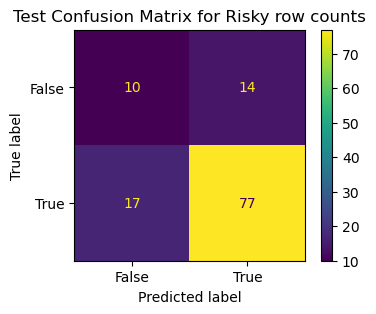

In [7]:
# print the confusion matrix, prediction is the CHECK_RiskyRow,
import matplotlib.pyplot as plt

cm = confusion_matrix(df["PRIVACY_Risky row counts_PASS"], df["CHECK_RiskyRow"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
fig, ax = plt.subplots(figsize=(4, 3))
disp.plot(ax=ax)
plt.title(f"Test Confusion Matrix for Risky row counts")
plt.show()

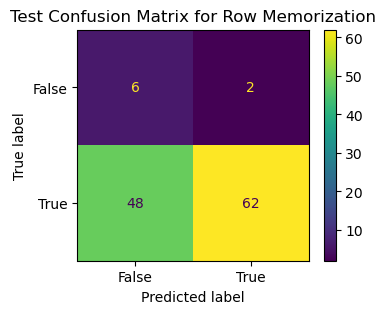

In [8]:
cm = confusion_matrix(df["PRIVACY_Row memorization_PASS"], df["CHECK_RowMemorization"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
fig, ax = plt.subplots(figsize=(4, 3))
disp.plot(ax=ax)
plt.title(f"Test Confusion Matrix for Row Memorization")
plt.show()

In [9]:
# create a function to evaluate the model and save the result to a csv file
def evaluate_model(y_test, y_pred, target_name, model_name, feature_name):
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f05_score = fbeta_score(y_test, y_pred, beta=0.5)
    f2_score = fbeta_score(y_test, y_pred, beta=2)
    f1 = f1_score(y_test, y_pred)
    specificity = confusion_matrix(y_test, y_pred)[0, 0] / sum(y_test == 0)
    sensitivity = confusion_matrix(y_test, y_pred)[1, 1] / sum(y_test == 1)

    # save to csv if the file already exists, delete the file otherwise and create a new one
    if os.path.exists(f"result/perf_{target_name}_{model_name}_{feature_name}.csv"):
        # delete the file
        os.remove(f"result/perf_{target_name}_{model_name}_{feature_name}.csv")
    with open(f"result/perf_{target_name}_{model_name}_{feature_name}.csv", "w") as f:
        f.write(
            "target_name,model_name,feature_name,accuracy,balanced_accuracy,f05_score,f2_score,f1,specificity,sensitivity\n"
        )
        f.write(
            f"{target_name},{model_name},{feature_name},{accuracy},{balanced_accuracy},{f05_score},{f1},{f2_score},{specificity},{sensitivity}\n"
        )

In [10]:
evaluate_model(
    df["PRIVACY_Risky row counts_PASS"],
    df["CHECK_RiskyRow"],
    "PRIVACY_Risky row counts",
    "base",
    "man",
)
evaluate_model(
    df["PRIVACY_Row memorization_PASS"],
    df["CHECK_RowMemorization"],
    "PRIVACY_Row memorization",
    "base",
    "man",
)